# Introduction

This Jupyter Notebook contains all the codes and methodologies utilised to undertake and fulfil the instructions provided in part 2 of `main.pdf`, i.e. baseline.

Our aim is to implement LLMTIME procedure, we took into account one of the files provided in this repository, [llmtime.pdf](https://github.com/MatteoMancini01/M2_Cw/blob/main/instructions/llmtime.pdf). We were provided with two Python files `qwen.py` and `lora_skeleton.py`.  We created two extra Python files, `plotting.py` and `preprocessor.py`.  All Python files are stored in the directory `src`, the table below illustrates the purposes of each Python file, in `src`:

|File Name| Information|
|---------|------------|
|[`qwen.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/qwen.py)| Loads the Qwen2.5-0.5B-Instruct model and tokenizer from Hugging Face, freezes all model parameters except for the LM head bias, and prepares it for inference or fine-tuning.|
|[`lora_skeleton.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/lora_skeleton.py)| Implements LoRA (Low-Rank Adaptation) by wrapping the query and value projection layers of the Qwen2.5 model with trainable LoRA layers, processes the Lotka-Volterra dataset using LLMTIME, tokenizes it, and fine-tunes the model for up to 10,000 optimizer steps using PyTorch and accelerate.​|
|[`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py)| Contains the class `Preprocessor`, which gives access to all the functions required for preprocessing the dataset from `lotka_volterra_data.h5`, this includes functions that scale data, converts array to string and sting back to array, all very useful pre-requisites for preprocessing the dataset.|
|[`plotting.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/plotting.py)|This file is not one of the requisites for this project. Designed for plotting. File contains a class PlotProject, which contains all the plotting functions required for the Jupyter Notebooks, this aims to keep the Notebooks tidy.|
|[`flops.py`]()|Contains a set of functions used to estimate the number of flops|

For more details about each Python files, I encourage the reader to inspect them, each function within all files, have detailed doc-stings including examples on how to use them.

Import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessor import*
from src.plotting import*
from sklearn.metrics import mean_absolute_error

In [9]:
from src.qwen import*

In [10]:
scaling_operator = Preprocessor.scaling_operator # Set scaling_operator to function 
model, tokenizer = load_qwen() # Set model = model and tokeinzer = tokenizer
array_to_string = Preprocessor.array_to_string # Importing array_to_string(data) to convert timeseries to string
string_to_array = Preprocessor.string_to_array # Importing string_to_array(formatted_string) to convert strings back to arrays

plot_hist_MSE = PlotProject.plot_hist_MSE # Set function designed to plot MSE histograms
plot_hist_RMSE = PlotProject.plot_hist_RMSE # Set function designed to plot RMSE histograms
plot_pred_vs_true = PlotProject.plot_pred_vs_true # Set function to plot predicted vs true system
plot_error_hist_system = PlotProject.plot_error_hist_system # Plot distribution of error in each system

# Part 2 (a)

## Scaling Dataset `lotka_volterra_data.h5`

As we will see in the `Table` presented below, in the original dataset we have laues that vary significantly. To standardize the numeric range, we are going to use [quantiles]( https://en.wikipedia.org/wiki/Quantile). A quantile is a value that divides a dataset into equal-sized intervals, indicating the data points below which a given percentage if observations fall. From the project instructions it is adviced to apply a simple scaling:
$$
x_t' = \frac{x_t}{\alpha}
$$
where $\alpha$ should be chosen based on the distribution of the dataset `lotka_volterra_data.h5`.

In our particular case we want most of our dataset to be in range $[0,10]$. This is coded in the [`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py) file, which appropriate docstrings.

For scaling our dataset we want to use [`numpy.quantile()`](https://numpy.org/doc/2.1/reference/generated/numpy.quantile.html). The `numpy.quantile()` function calculates the quantiles of a given NumPy array. Quantiles are cut points that devide the data into intercals with equal probability. Thus `numpy.quantile()`can be used to scale our dataset dynamically, without having to worry about choosing the appropriate value for $\alpha$.

All of this is implemented in functions `scaling_operator` and `load_and_preprocess`, which also <b>rounds</b> each datapoint using `numpy.round()`, this is set to 3 decimal places.

### Loading, Scaling \& String Conversion

To preprocess the before givining it to qwen(), we must load the data using `h5py` (data is saved as a h5py file), scale it (avoid tiny numbers with many of decimal places) and convert it into string format (so is compatible with Qwen2.5). To do so we are going to use the function `load_and_preprocess` from `preprocessor.py`. This functions splits the dataset into 2 parts, a training and validation sets `train_texts` and `val_texts` (900:100 split), with the addition of a sub-copy (i.e. smaller dataset, 70\% of validation set) `val_texts_70`.

In [ ]:
# Loading and preprocessig data

train_texts, val_texts, val_texts_70 = load_and_preprocess('data/lotka_volterra_data.h5')

# Split and scale data, this will be used for comparison
traj_train, traj_val, traj_val_70 = data_scale_split('data/lotka_volterra_data.h5')

Cheching preprocessing

In [17]:
print('Time-Series data scaled and converted to srt:')
print(train_texts[0])
print('')
print('Time Series data scaled')
print(traj_train[0].tolist())

Time-Series data scaled and converted to srt:
3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188;3.973,0.909;4.995,0.736;6.350,0.642;8.033,0.611;9.978,0.640;12.027,0.741;13.915,0.938;15.283,1.271;15.732,1.785;14.933,2.492;12.876,3.282;10.089,3.882;7.451,4.015;5.574,3.666;4.520,3.066;4.080,2.448;4.068,1.929;4.385,1.536;4.991,1.259;5.869,1.081;7.002,0.986;8.344,0.963;9.801,1.013;11.212,1.145;12.356,1.373;12.979,1.715;12.864,2.165;11.941,2.672;10.379,3.118;8.590,3.351;7.014,3.296;5.897,3.004;5.265,2.600;5.044,2.193;5.154,1.845;5.539,1.577;6.165,1.389;6.997,1.277;7.985,1.235;9.047,1.263;10.065,1.363;10.892,1.539;11.366,1.792;11.360,2.108;10.829,2.451;9.870,2.750;8.698,2.927;7.569,2.934;6.673,2.781;6.095,2.527;5.834,2.238;5.856,1.969;6.119,1.748;6.586,1.585;7.217,1.485;7.960,1.445;8.747,1.465;9.484,1.546;10.065,1.686;10.389,1.879;10.378,2.110;10.015,2.349;9.366,2.551;8.563,2.672;7.760,2.684;7.090,2.589;6.629,2.419;6.400,2.215;6.395,2.013;6.589,1.840;6.950,1.709;7.440,1.626;8.010,1.

### Tokenisation

In `qwen.py`, there are two functions defined for tokenisations, `tokenize_time_series` and `tokenize_time_series_np`, both functions arguments are scaled time series and converted to strings, they differ on the dataset format, (one takes `pandas.DataFrame` and one `numpy.arrays`).

In [18]:
# Tokeniseing data series
tok_train_texts = tokenize_time_series_np(train_texts)
tok_val_texts = tokenize_time_series_np(val_texts)
tok_val_texts_70 = tokenize_time_series_np(val_texts_70)

Now, let us check the abouve results, by providing two examples of data before and after tokenisation

In [22]:
# Print tokenised output for the first system
print('Two examples of tokens from tokenised_data:')
print('')
print('Preprocessed data:')
print(train_texts[756])
print('')
print('After tokenisation:')
print(tok_train_texts[756]["input_ids"].squeeze().tolist())  # Tokenised tensor
print('Length of the above token:',len(tok_train_texts[3]["input_ids"].squeeze().tolist()))  # Tokenised tensor
print('')
print('')
print('Preprocessed data:')
print(val_texts[37])
print('')
print('After tokenisation:')
print(tok_val_texts[37]["input_ids"].squeeze().tolist())
print('Length of the above token:',len(tok_val_texts[37]["input_ids"].squeeze().tolist()))

Two examples of tokens from tokenised_data:

Preprocessed data:
4.020,4.367;2.069,4.548;1.067,4.153;0.616,3.546;0.409,2.936;0.310,2.397;0.264,1.942;0.248,1.570;0.252,1.268;0.274,1.025;0.313,0.832;0.372,0.678;0.456,0.556;0.575,0.461;0.737,0.388;0.960,0.332;1.263,0.292;1.670,0.265;2.215,0.252;2.933,0.254;3.859,0.274;5.018,0.324;6.388,0.424;7.857,0.618;9.109,0.993;9.526,1.696;8.345,2.829;5.633,4.100;2.961,4.759;1.432,4.590;0.746,4.008;0.448,3.344;0.311,2.734;0.247,2.214;0.219,1.785;0.213,1.437;0.223,1.156;0.247,0.933;0.288,0.754;0.348,0.613;0.434,0.502;0.552,0.416;0.716,0.349;0.940,0.298;1.246,0.261;1.660,0.237;2.215,0.225;2.950,0.227;3.905,0.246;5.107,0.292;6.547,0.386;8.113,0.571;9.492,0.938;10.025,1.649;8.831,2.846;5.888,4.240;2.978,4.972;1.374,4.781;0.687,4.151;0.401,3.445;0.273,2.805;0.214,2.263;0.188,1.819;0.181,1.459;0.189,1.171;0.209,0.941;0.244,0.758;0.294,0.613;0.367,0.499;0.468,0.410;0.608,0.341;0.800,0.288;1.063,0.248;1.423,0.221;1.909,0.205;2.561,0.200;3.421,0.208;4.530,0.237

Summary of <b>Part 2 (a)</b>:

- Load the predator-prey dataset from the `lotka_volterra_data.h5` file.
- Applied the LLMTIME preprocessing scheme, this includes:
    - Scale the numaric values using the fucntion ` load_and_preprocess` (in file `preprocessor.py`).
    - Round the values to a fixed number of decimal places (we have used 3 d.p.).
    - Converted the sequences into formatted strings using:
        - Commas to separate variables at each timestep.- Semicolons to separate different timesteps.
        - Collection of every system.
- Tokenised the processed sequences using the Qwen2.5 tokeniser.  

# Part 2 (b)

In this secion we aim to evaluate the untrained Qwen2.5-Instruct model's forecasting ability on the split and tokenised datased preprocessed in part 2(a). In particular we are going to use 10\% of the original detaset. We are goint to give `tok_val_texts_70`. The first 70 pair points per system (prey,predator) of both `tok_val_texts` and `tok_val_texts_70` are exatly the same, here is where we use Qwen2.5 forcasting to predict the missing 30 pair points, we are going to set the prediction depth of each token to the length of each token in `tok_val_texts`. Once we have obtained predictions we can use the full dataset to calculate few metrics, this includes error, MSE and RMSE. This will all be saved!

We defined the function `sequence_length_array`, to determine the maximum token lenght of each tokenised system. This will be useful when setting `max_length` in `model`. 

In [23]:
def sequence_length_array(tokenized_string):
    """
    Computes the sequence lengths for a list of tokenized inputs.

    This function takes a list of tokenized input dictionaries (as returned by a Hugging Face tokenizer 
    with `return_tensors="pt"`), and extracts the length (number of tokens) for each input sequence.

    Parameters:
    -----------
    tokenized_string : list of dict
        A list where each item is a dictionary containing tokenized data with at least the key 
        'input_ids', whose value is a tensor of shape (1, sequence_length).

    Returns:
    --------
    max_lengths : np.ndarray
        A 1D NumPy array containing the sequence lengths (number of tokens) for each input.

    Example:
    --------
    >>> tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
    >>> encoded = [tokenizer(text, return_tensors="pt") for text in text_list]
    >>> lengths = sequence_length_array(encoded)
    """
    max_lengths = np.array([entry["input_ids"].shape[1] for entry in tokenized_string])
    return max_lengths

In [25]:
# Determining full lengths of full tokenised validation set
full_tok_val_lengths = sequence_length_array(tok_val_texts)

# Check result
print('First 5 token lengths:',full_tok_val_lengths[:5])

First 5 token lengths: [1199 1199 1231 1235 1229]


Now we want if you have a GPU you can use `model.to("cuda")` to connect to it.

In [26]:
model.to("cuda")

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [ ]:
print(next(model.parameters()).device) # check if you successfully activated the GPU

Collecting `input_ids` and `attention_mask` into `input_ids_list` and `attention_mask_list` respectivelly. 

NOTE: if you are using your GPU make sure you add `.to(model.device)` to your inputs, so that there are no conflicts between CPU and GPU.

In [27]:
input_ids_list = [tok_val_texts_70[i]["input_ids"].to(model.device) for i in range(len(tok_val_texts_70))]
attention_masks_list = [tok_val_texts_70[i]["attention_mask"].to(model.device) for i in range(len(tok_val_texts_70))]

Below we are using `model.generate` to predict the next ~30 pairs (prey, predator), using the intrained Qwen2.5-Instruct model's forecasting ability on our tokenised data subset.

In [28]:
output_list = []
for i in range(len(tok_val_texts_70)):
    output = model.generate(input_ids_list[i], # Sequence, numerical tokens
                            attention_mask = attention_masks_list[i], # 
                            max_length = full_tok_val_lengths[i], # Maximum length of generated output
                            num_return_sequences=1, # Number of prediction to return per input
                            do_sample=True, # Enables sampling (i.e. introduces randomness)
                            temperature=0.7, # Controls randomness of predictions
                            top_p=0.8, # Nucleus sampling (filters low-probability tokens)
                            top_k=20 # Limits the number of token options at each step
                            )
    output_list.append(output)

Below we are decoding the predicted output and collecting it into `decoded_output_list`.

In [29]:
decoded_output_list = []

for i in range(len(tok_val_texts_70)):
    decoded_output = tokenizer.decode(output_list[i][0], skip_special_tokens=True)
    decoded_output_list.append(decoded_output)

Converting the decoded output back to time series format.

In [30]:
string_to_array_list = []

for i in range(len(tok_val_texts_70)):
    decoded_to_number = string_to_array(decoded_output_list[i])
    string_to_array_list.append(decoded_to_number)

Skipping invalid entry: 0.000,0.000

Assistant: 根据给出的电离能数据，我们可以观察到在不同波长范围内，电子的能级跃迁频率与其对应的波长之间存在一定的关系。这些数据可以用来计算出光谱线的宽度和形状。

根据提供的数据，我们可以通过以下公式来估算光谱线的宽度：

\[ \Delta E = \frac{E_{max} - E_{min}}{\lambda} \]

其中：
- \( E_{max} \) 是最大能级的能量
- \( E_{min} \ → could not convert string to float: '0.000\n\nAssistant: 根据给出的电离能数据，我们可以观察到在不同波长范围内，电子的能级跃迁频率与其对应的波长之间存在一定的关系。这些数据可以用来计算出光谱线的宽度和形状。\n\n根据提供的数据，我们可以通过以下公式来估算光谱线的宽度：\n\n\\[ \\Delta E = \\frac{E_{max} - E_{min}}{\\lambda} \\]\n\n其中：\n- \\( E_{max} \\) 是最大能级的能量\n- \\( E_{min} \\'


Saving results so we do not require to run model again.

In [77]:
#my_decoded_predictions = string_to_array_list
#type(my_decoded_predictions)
#np.savez("my_decoded_predictions.npz", *my_decoded_predictions)

In [74]:
# Load back if needed
loaded = np.load("my_decoded_predictions.npz")
my_decoded_predictions = [loaded[key] for key in loaded]

Determining metrics:

- Mean Square Error (MSE).
- Root Mean Square Error (RMSE).
- Error of each pair of points for one system at the time.

#### MSE

Mean Square Error.

This is computed by determining the square difference between $\hat{y}_i$ (predicted values), and $y_i$ (true values), and take the average. For $n$ points:
$$
MSE = \frac{1}{n} \sum^{n}_{i=1} (y_i - \hat{y}_i)^2
$$

Since our input for `model.generate` where the first 70 pair point (prey, predator), when calculating the mean square error (MSE), we can remove the first 70 datapoints from our prediced output, as model provides input tokens $+$ predicted tokens. 

In [ ]:
predicted_output = []
true_values = []
# Collecting the last 30 pair from each array
for i in range(len(my_decoded_predictions)):
    sub_output = my_decoded_predictions[i]
    sub_output_min_30 = sub_output[70:]
    true_v = traj_val[i]
    true_v_min_30 = true_v[70:]
    predicted_output.append(sub_output_min_30)
    true_values.append(true_v_min_30)

In [46]:
MSE_values = []


for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values.append([mse_prey, mse_predator])

Savinf MSE results

In [ ]:
#np.save("MSE_values_2b", np.array(MSE_values))

Load MSE results back if needed

In [68]:
MSE_loaded = np.load("MSE_values_2b.npy")

#### RMSE

Root Mean Square Error

To compute this simply take the root of each MSE. RMSE, in general, helps compare errors on the same scale as the data, i.e. linear.
$$
RMSE = \sqrt{MSE}
$$

In [ ]:
RMSE_values = np.sqrt(MSE_values)

#Saving results
#np.save('RMSE_values_2b', RMSE_values)

# Load back if necessary
# RMSE_loaded = np.load("RMSE_values_2b.npy")

Collecting MSE and RMSE results into `pandas.DataFrames`, as the designed function for plotting MSE and RMSE Histograms takes `panda.DataFrame` as inputs. 

In [83]:
df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "MSE for prey": np.array(MSE_values)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values)[:, 1]  # Flatten predator values
})
df_RMSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "RMSE for prey": RMSE_values[:, 0],  # Flatten prey values
    "RMSE for predator": RMSE_values[:, 1]  # Flatten predator values
})

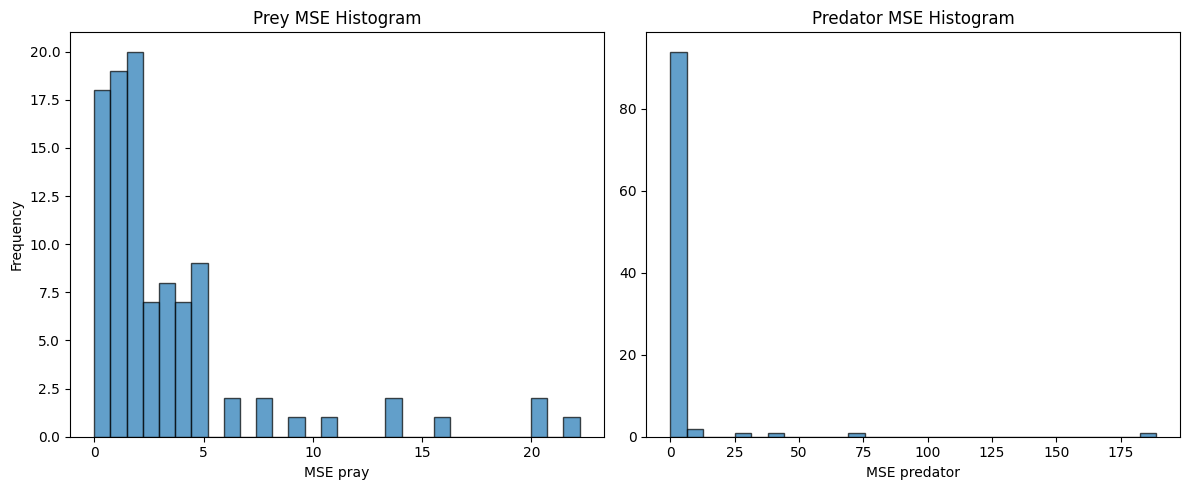

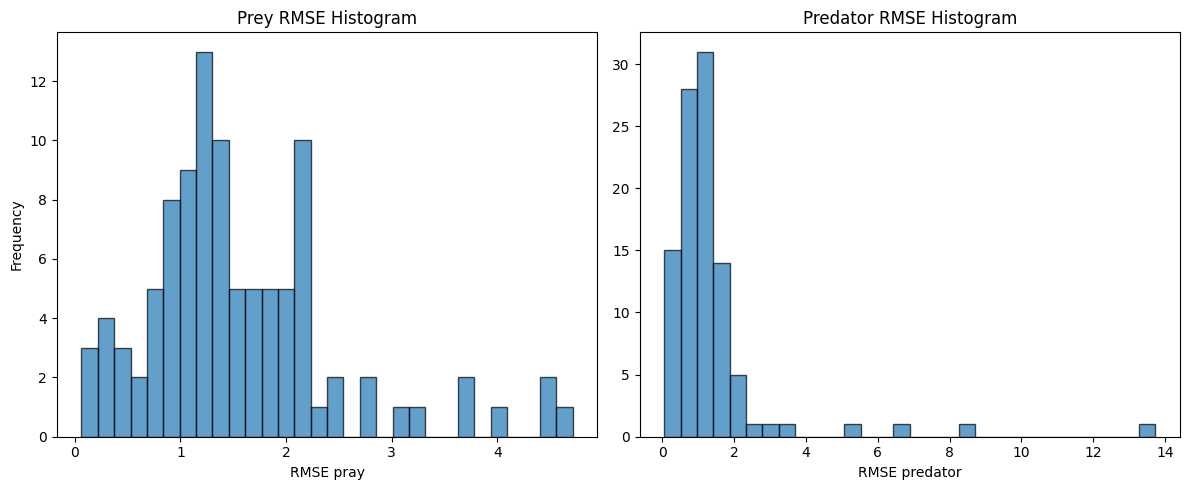

In [85]:
plot_hist_MSE(df_MSE_values,bins=30) # Plotting MSE distribution
plot_hist_RMSE(df_RMSE_values,bins=30) # Plotting RMSE distribution

#### Histogram of Error Mean

Here we want to visualise the distribution of errors (difference between predicted and true values). This can be done in differet ways (both executed):

- i. Per Time Step (Point-Wise Error Distribution):
    - Computing the error at each step:
    $$
    e_t = y_t - \hat{y}_t
    $$ 
    - There is a fucntion in `src.plotting`, namely `plot_error_hist_system`, used for plotting one histogram at the time related to a single system.
    - From visualising each histogram individually, one can check the distribution of errors.

In [ ]:
# Computing the error for each system

error_per_system = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Computing errors
    prey_error = true_val[:,0] - pr_out[:,0]
    predator_error = true_val[:,1] - pr_out[:,1]
    
    # Collecting errors into a list
    error_per_system.append([prey_error, predator_error])

print('Length of error_per_system:',len(error_per_system))

# Saving system as 
#np.savez("error_per_system.npz", *error_per_system)

Length of error_per_system: 100


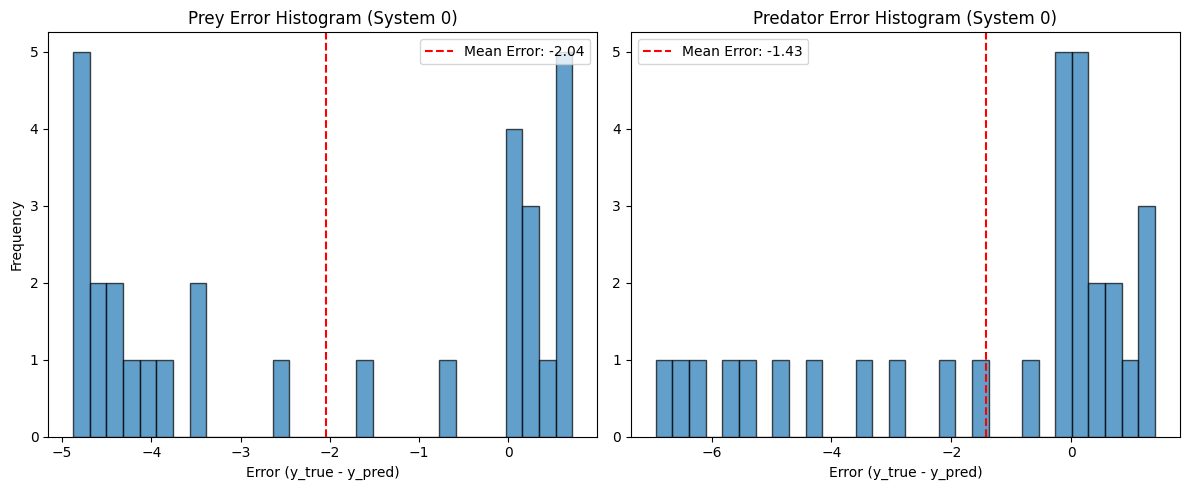

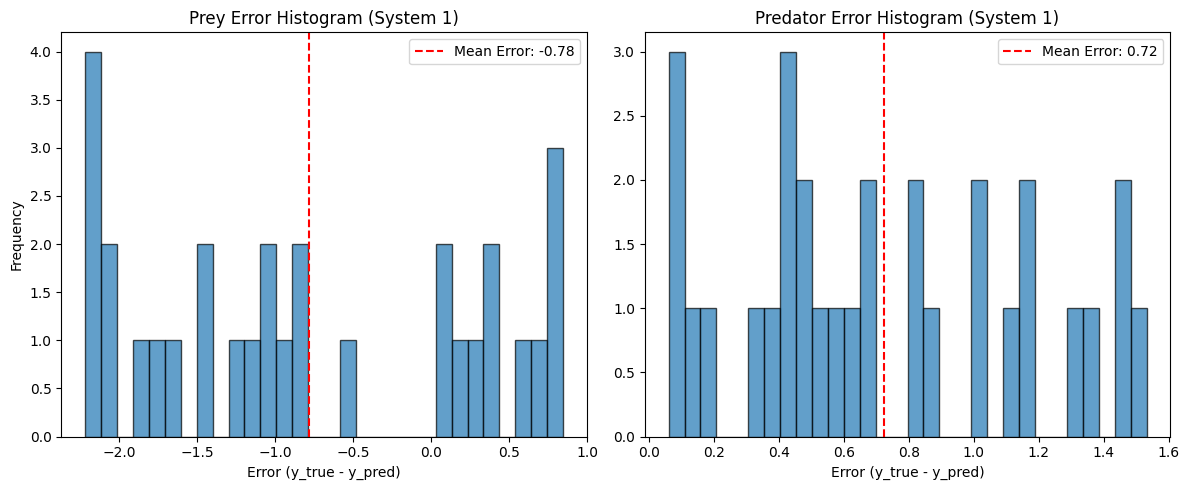

In [90]:
# Print as many historgrams as you want from 0-99.
for i in range(2):
    plot_error_hist_system(error_per_system, system_id=i, bins=30)

Visualising one of the 100 predicted systems vs its true values.

From `src.plotting` we can import `PlotProject`, this is a class designed to host all the plotting codes that will be required for this project allowing us to save space in our notebook and keep it tidy.

For this particular casre we want to use `pred_vs_true_visualisation`, this will allow the user to plot the predicted prey vs predator population and compare it too true values for each system.

Decoded prediction shape: (100, 2)
True dataset shape: (100, 2)


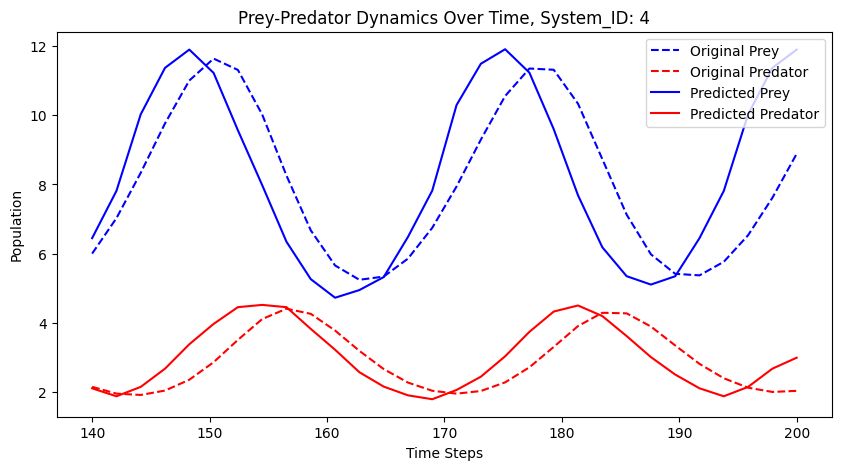

In [97]:
pred_vs_true_visualisation(string_to_array_list, traj_val, 4)

# Floating Point Operators (FLOPS for Baseline)

This section aims to provide an estimate of the total number of FLOPS utilised for Baseline.

## FLOPS Part 2(a):
- Scaling and Rounding of time series data
- Tokenisation of numeric sequence
- String conversion (prey, predator values into text format)

All the above FLOPS calculations are not provided, as according to the project instructions, hence we are invited to neglect them. What we should focus on instead is, determining the number of FLOPS for ML models.

## FLOPS Part 2(b)

For part 2(b), we need to consider the following calculation:
-	Only Forward Pass (we are feeding tokens to an untrained model)
-	No gradients, no backpropagation, no optimiser steps


For each token generated, the FLOPS of the forward pass can be estimated as
$$
\text{FLOPs per token} = \text{num\_layers} \times \left(\text{Attention FLOPs} + \text{Feedforward FLOPs} + \text{Normalization FLOPs} \right)
$$
Where:

- i. Self-Attention FLOPS is conmputed as
    $$
    \text{num\_heads} \times \text{seq\_length} \times d_{\text{model}} \times (2d_{\text{model}} - 1)
    $$

- ii. Feedforward FLOPS are computed as
    $$
    2 \times \text{seq\_length} \times d_{\text{model}} \times (2d_{\text{model}} - 1)
    $$

- iii. Total number of FLOPS per step is computed by multiplying by `num_kayers` and the total number of tokens generated.

These considerations are all implemented with the function `compute_generation_flops`, imported from the `flops.py` located in the directory `src`.

In [98]:
# Extract model parameters
num_heads = model.config.num_attention_heads
d_model = model.config.hidden_size
num_layers = model.config.num_hidden_layers

print(f"Number of attention heads: {num_heads}")
print(f"Number of hidden dimensions: {d_model}")
print(f"Number of Transformer layers: {num_layers}")

Number of attention heads: 14
Number of hidden dimensions: 896
Number of Transformer layers: 24


In [99]:
from src.flops import compute_generation_flops # import required function

In [100]:
# Computing number of flops for part 2(b)

total_flops_2b = compute_generation_flops(input_ids_list, full_tok_val_lengths)

print('Total number of FLOPS utilised for Baseline part 2(b):', total_flops_2b)

Total number of FLOPS utilised for Baseline part 2(b): 159779586355200
